In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00484_2.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00541_4.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00305_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00052_2.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00218_2.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00353_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00013_3.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00093_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00559_4.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00518_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00554_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data

In [7]:
pip install -U git+https://github.com/qubvel/segmentation_models.git

  Cloning https://github.com/qubvel/segmentation_models.git to /tmp/pip-req-build-omvg4i8t
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-omvg4i8t
  Resolved https://github.com/qubvel/segmentation_models.git to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33789 sha256=e36a66a401b323faf08e12b7ed951341f6fa61febbb1a87850f22f2830c46068
  Stored in directory: /tmp/pip-ephem-wheel-cache-ife8n8u2/wheels/16/9b/76/6e33fba6f1888d8c6e0faf79bb28198229cb8dfab1a502558d
Successfully built segmentation_models
Note: you may need to restart the kernel to use updated packages.


100%|██████████| 2940/2940 [01:32<00:00, 31.69it/s]


✅ Data loaded:
X_train shape: (2940, 128, 128, 3)
Y_train shape: (2940, 128, 128, 1)
Max value in X_train: 255
Unique values in Y_train: [False  True]


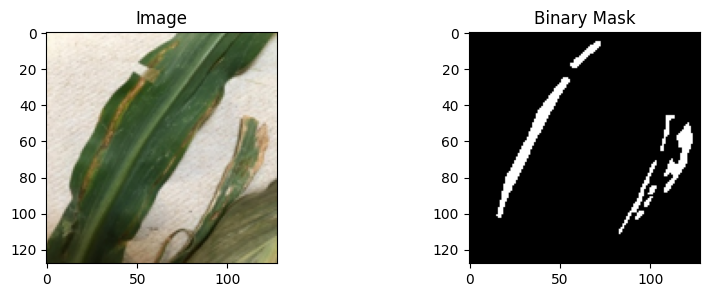

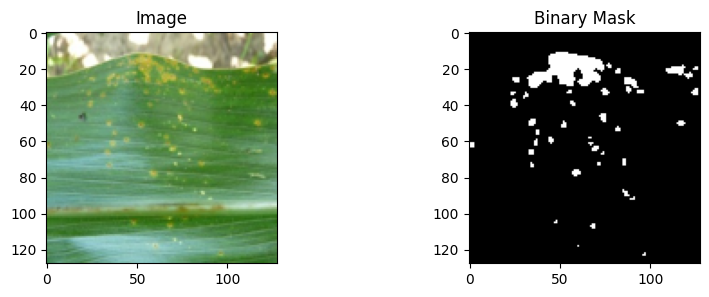

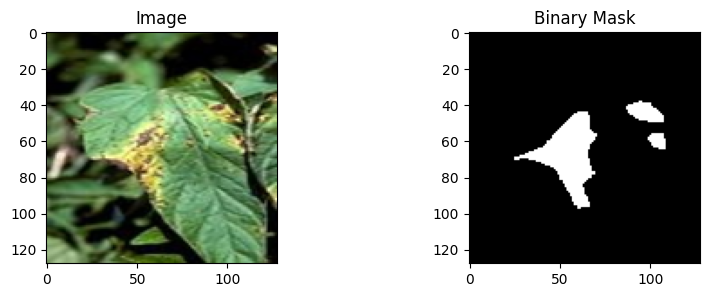

In [8]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Directories of the augmented dataset
train_image_dir = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images"
train_mask_dir  = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks"

image_files = [f for f in os.listdir(train_image_dir) if f.endswith(".jpg")]

X_train = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

for i, file_name in enumerate(tqdm(image_files)):
    img_path = os.path.join(train_image_dir, file_name)
    mask_name = os.path.splitext(file_name)[0] + ".png"  # replace .jpg with .png
    mask_path = os.path.join(train_mask_dir, mask_name)

    if not os.path.exists(mask_path):
        print(f"⚠️ No mask exists for: {mask_name}")
        continue

    img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT))
    mask = Image.open(mask_path).convert("L").resize((IMG_WIDTH, IMG_HEIGHT))

    mask_array = np.array(mask)

    if np.max(mask_array) == 0:
        print(f"⚠️ Empty mask for: {mask_name}")

    X_train[i] = np.array(img)
    Y_train[i] = np.expand_dims(mask_array > 10, axis=-1)  # binarization

print("✅ Data loaded:")
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("Max value in X_train:", np.max(X_train))
print("Unique values in Y_train:", np.unique(Y_train))

# Display a few images and masks
for i in range(3):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i])
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(Y_train[i].squeeze(), cmap="gray")
    plt.title("Binary Mask")
    plt.show()


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from skimage.transform import resize

2025-07-31 11:07:36.511629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753960056.740331      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753960056.813249      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
def build_backbone(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_shape=input_shape
    )

    layer_names = [
        "conv2_block3_out",  # 1/4 resolution
        "conv3_block4_out",  # 1/8
        "conv4_block6_out",  # 1/16
    ]
    layers_output = [base_model.get_layer(name).output for name in layer_names]
    backbone = tf.keras.Model(inputs=base_model.input, outputs=layers_output)
    backbone.trainable = False  # puedes cambiarlo si deseas fine-tuning
    return backbone

In [11]:
def ASPP(x):
    dims = x.shape
    y1 = layers.Conv2D(256, 1, padding="same", activation="relu")(x)
    y2 = layers.Conv2D(256, 3, dilation_rate=6, padding="same", activation="relu")(x)
    y3 = layers.Conv2D(256, 3, dilation_rate=12, padding="same", activation="relu")(x)
    y4 = layers.Conv2D(256, 3, dilation_rate=18, padding="same", activation="relu")(x)
    y5 = layers.GlobalAveragePooling2D()(x)
    y5 = layers.Reshape((1, 1, y5.shape[1]))(y5)
    y5 = layers.Conv2D(256, 1, padding="same", activation="relu")(y5)
    y5 = layers.UpSampling2D(size=(dims[1], dims[2]), interpolation="bilinear")(y5)
    
    y = layers.Concatenate()([y1, y2, y3, y4, y5])
    return layers.Conv2D(256, 1, padding="same", activation="relu")(y)

def DeepLabV3Plus(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    backbone = build_backbone(input_shape)
    low_level_feat, mid_feat, high_feat = backbone(inputs)

    x = ASPP(high_feat)
    x = layers.Dropout(0.3)(x)  # added dropout
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    low = layers.Conv2D(48, 1, padding="same", use_bias=False)(low_level_feat)
    low = layers.BatchNormalization()(low)
    low = layers.Activation("swish")(low)

    x = layers.Concatenate()([x, low])

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    x = layers.Dropout(0.3)(x)  # added dropout
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    outputs = layers.Conv2D(num_classes, 1, activation="sigmoid")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [12]:
model = DeepLabV3Plus()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=8
)

2025-07-31 11:07:52.056270: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 32, 32,   │  8,589,184 │ input_layer[0][0] │
│ (Functional)        │ 256), (None, 16,  │            │                   │
│                     │ 16, 512), (None,  │            │                   │
│                     │ 8, 8, 1024)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ functional[0][2]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ global_average_p… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 256) │    262,400 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 8, 256) │    262,400 │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 256) │  2,359,552 │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 256) │  2,359,552 │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │  2,359,552 │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 8, 8, 256) │          0 │ conv2d_4[0][0]    │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 1280)             │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_3[0][0],   │
│                     │                   │            │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 256) │    327,936 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     12,288 │ functional[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 8, 256) │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        192 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 32, 32,    │          0 │ dropout[0][0]     │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 17,825,601 (68.00 MB)

 Trainable params: 9,235,297 (35.23 MB)

 Non-trainable params: 8,590,304 (32.77 MB)

Epoch 1/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 749s 2s/step - accuracy: 0.8444 - loss: 0.3614 - val_accuracy: 0.8824 - val_loss: 0.3699
Epoch 2/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 739s 3s/step - accuracy: 0.9085 - loss: 0.2157 - val_accuracy: 0.9068 - val_loss: 0.2161
Epoch 3/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 728s 2s/step - accuracy: 0.9228 - loss: 0.1842 - val_accuracy: 0.9338 - val_loss: 0.1618
Epoch 4/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 767s 3s/step - accuracy: 0.9329 - loss: 0.1611 - val_accuracy: 0.9363 - val_loss: 0.1541
Epoch 5/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 731s 2s/step - accuracy: 0.9410 - loss: 0.1425 - val_accuracy: 0.9442 - val_loss: 0.1374
Epoch 6/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 728s 2s/step - accuracy: 0.9477 - loss: 0.1271 - val_accuracy: 0.9460 - val_loss: 0.1328
Epoch 7/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 727s 2s/step - accuracy: 0.9501 - loss: 0.1217 - val_accuracy: 0.9413 - val_loss: 0.1566
Epoch 8/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 724s 2s/step - accuracy: 0.9549 - loss: 0.1095 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


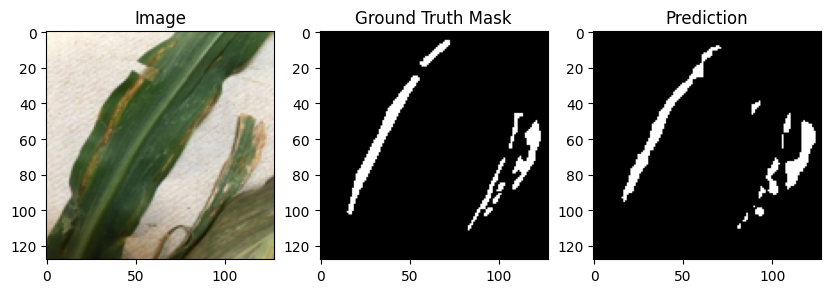

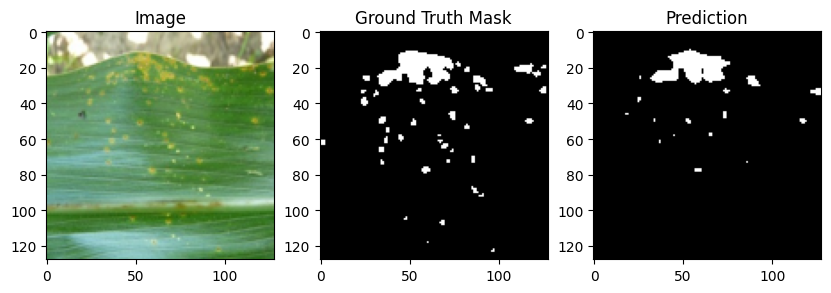

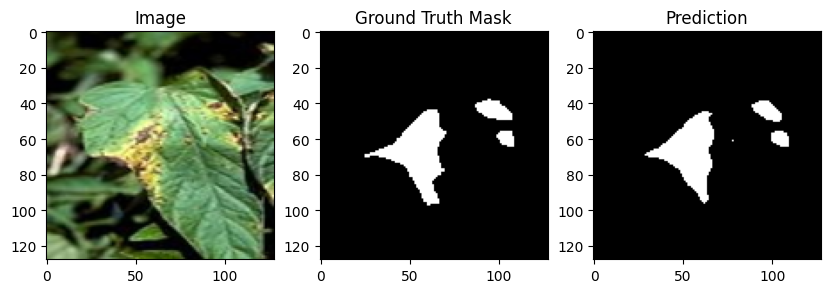

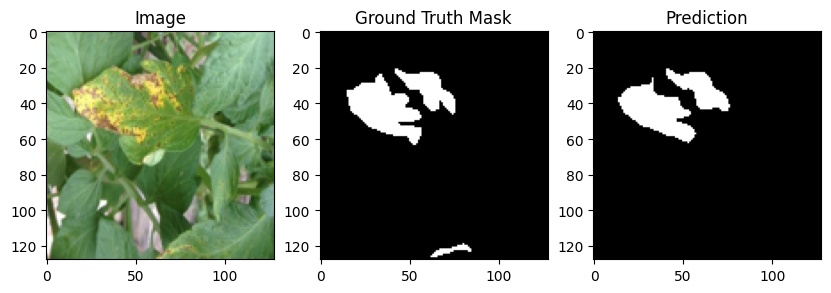

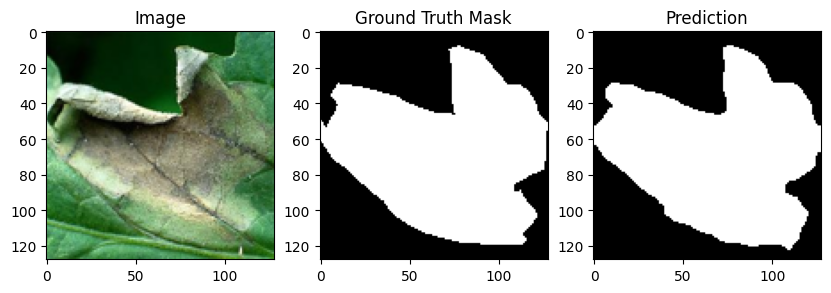

In [13]:
preds = model.predict(X_train[:5])
for i in range(5):
    plt.figure(figsize=(10, 3))
    
    plt.subplot(1, 3, 1)
    plt.imshow(X_train[i])
    plt.title("Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(Y_train[i].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].squeeze() > 0.5, cmap="gray")
    plt.title("Prediction")
    
    plt.show()

In [14]:
# The 'history' object already contains the training history
train_acc = history.history['accuracy'][-1]        # Final training accuracy
val_acc = history.history['val_accuracy'][-1]      # Final validation accuracy

# A value you stored for final accuracy in your block 9
unetacc = train_acc  

print(f"Final training accuracy: {train_acc:.4f}")
print(f"Final validation accuracy: {val_acc:.4f}")

Final training accuracy: 0.9698
Final validation accuracy: 0.9570


In [15]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, Dropout, BatchNormalization

def DeepLabV3Plus(input_shape=(128, 128, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    # Load EfficientNetB0 backbone
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)

    # Use feature maps from intermediate layers
    skip_connection = base_model.get_layer("block2a_activation").output  # low-level features
    x = base_model.get_layer("block6a_activation").output                # high-level features

    # ASPP-like decoder (simplified)
    x = Conv2D(256, 3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)  # Upsample high-level features
    skip = Conv2D(48, 1, padding="same", activation="relu")(skip_connection)
    skip = BatchNormalization()(skip)

    x = Concatenate()([x, skip])
    x = Conv2D(256, 3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    outputs = Conv2D(num_classes, 1, activation="sigmoid")(x)

    return Model(inputs, outputs)